Due to rendering limitations in GitHub some plots in this notebook are not displayed when viewed on GitHub. To see a version of this notebook with all plots correctly rendered please visit this page:<br>
https://nbviewer.jupyter.org/github/PriyankaChakraborti/CoFFee-Shop-Blues/blob/master/NLP.ipynb

The user first chooses the city they want to investigate and the type of coffee shop they are trying to open

In [130]:
chosen_city = 'Washington'
chosen_shop_type = 'chain'
chosen_neighborhood = 'Truxton Circle'

In [131]:
from __future__ import print_function
import argparse
import geopandas as gpd
import json
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pandas as pd
import pprint
import pylab as pl
import requests
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
import seaborn as sns
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import shutil 
import sys
import urllib
import urllib.request 
import zipfile
import statistics
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode
    
from pandas.io.json import json_normalize
from shapely.geometry import Point
from ast import literal_eval
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split,GridSearchCV

from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorBar, GeoJSONDataSource, LogTicker
from bokeh.io import show, output_notebook
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import inferno
from bokeh.plotting import figure, save

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

In [132]:
#NLP libraries
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [133]:
from shapely.wkt import loads
path = 'coffee_data/COFFEE'
df_city=pd.read_csv(path+'/{}_data.csv'.format('COFFEE'))
df_city = df_city.drop_duplicates(subset='Name', keep='first')# Drop any duplicate neighborhoods

df_city_map=pd.read_csv(path+'/{}_map.csv'.format('COFFEE'))
df_city_map = df_city_map.drop_duplicates(subset='Name', keep='first')# Drop any duplicate neighborhoods

gdf_city_map = gpd.GeoDataFrame(df_city_map)
gdf_city_map['geometry']=gdf_city_map['geometry'].apply(lambda x: loads(x))
gdf_city_map = gdf_city_map.set_geometry('geometry')

In [134]:
API_KEY='95O5wTYIIMd_uKdNFFoth0pjjhcDCNL4X8ovL8LG8oGnGuOclw2Ntp2zZOrYPRB4f9DDBHX3faAD_u8rt4Q-bHOoDT8YuBnDJAwL1UdrVbpAgBcytfsUWdnos-LlXHYx'
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/'

In [135]:
#old definitions 
def search(host, path, business_id, bearer_token, url_params=None):
    """Given a bearer token, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        bearer_token (str): OAuth bearer token, obtained using client_id and client_secret.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}{2}{3}'.format(host, quote(path.encode('utf8')), quote(business_id.encode('utf8')),'/reviews')
    #print(url)
    headers = {
        'Authorization': 'Bearer %s' % bearer_token,
    }

    #print(u'Querying {0} ...'.format(url))
    
    i = 0
    timed_out = True
    while (timed_out == True) and (i <= 5):
        timed_out = False
        response = requests.request('GET', url, headers=headers, params=url_params)
#         print(response.status_code)
        if 'error' in response.json():
            if response.json()['error']['code'] == 'REQUEST_TIMED_OUT':
                # try again up to 5 times
                timed_out = True
                i += 1

    return response.json()



In [136]:
#create Dict 
#clean up initial pull from the dictionary and create an easily understandable dataframe
def filtered_coffee(df):
    '''
    Returns dataframe with only necessary columns, and cleaned in such a way as we will need them later.
    '''
    
    review_id=[item['id'] for item in df['reviews']]
    review_date=[item['time_created'] for item in df['reviews']]
    review_text=[item['text'] for item in df['reviews']]
#     location = list(zip(df['coordinates.latitude'], 
#                              df['coordinates.longitude']))

    columns = ['Review_Id', 'Time_Created','Text']
    data = [review_id, review_date,review_text]


    filtered_coffee = pd.DataFrame(data = dict(zip(columns, data)))
    filtered_coffee = filtered_coffee[columns]
    return filtered_coffee


In [137]:
def find_coffee(search_id=1,loops=10):
    
    '''
    The main workhorse here, this pulls all of the coffee shop reviews from yelp, doing many exhausting cycles.
    '''
    
    coffee_shops_df = pd.DataFrame()
    #print(search_id)
    url_params={}
    #loops=1
    for i in range(loops):
        try:
            # max api allows is 3 per pull
            coffee_results = search(API_HOST,SEARCH_PATH, search_id, API_KEY, url_params)
            #print(coffee_results)
        except IndexError:
            # error raised once no more coffee shops in the area are found.
            # this loop allows to capture the largest remaining no. of coffee shops
            for j in range(3, -1, -1): 
                if j == 0:
                    break
                try:
                    coffee_results = search(API_HOST,SEARCH_PATH, search_id, API_KEY, url_params)
                except IndexError:
                    continue
                break

        try:
            coffee_results = filtered_coffee(coffee_results)
            if isinstance(coffee_shops_df, pd.DataFrame):
                coffee_shops_df = pd.concat([coffee_shops_df, coffee_results])
                coffee_shops_df.reset_index(drop=True, inplace=True)
            else:
                coffee_shops_df = coffee_results
        except KeyError:
            break
      
    #print(coffee_results) 
    try:
        coffee_shops_df = coffee_shops_df.drop_duplicates('Review_Id').reset_index(drop=True)
    except AttributeError:
        #pass
        print('Resturant Had no reviews for {}'.format(search_id))
        
    #coffee_shops_df = coffee_shops_df[coffee_shops_df['Review_Count'] > 5]
    #coffee_shops_df = coffee_shops_df[coffee_shops_df['Categories'].apply(lambda x:('Coffee & Tea' or 'Coffee Roasteries' or 'Cafes') in x)]
            
    return coffee_shops_df


In [138]:
def merge_reviews(bus_list,loops):
    review_data_df=[]
    
    for i in range(len(bus_list)):
        shop_id=bus_list[i]
        
        city_results=find_coffee(shop_id,loops)
        if city_results.empty:
            continue
        
        if 'Review_Id' in city_results.columns:
            city_results.drop(columns='Review_Id',inplace=True)
        city_results['Time_Created']=city_results['Time_Created'].apply(lambda x:x.split()[0]) 
        bus_id=[shop_id]*city_results.shape[0]
        city_results['B_Id']=bus_id
        #print(city_results)
        if isinstance(review_data_df, pd.DataFrame):
            review_data_df=pd.concat([review_data_df,city_results])
            review_data_df.reset_index(drop=True,inplace=True)
        else:
            review_data_df=city_results
        if i % 50 == 0:
            print(i)
        
    # Sometimes API gets stuck after many consecutive call, wait after each call
        time.sleep(0.1)
    #print(review_data_df)    
 #  groupby business id and create list of all texts
    key_time=dict(review_data_df.groupby('B_Id')['Time_Created'].apply(lambda x:list(x)))
    key_text=dict(review_data_df.groupby('B_Id')['Text'].apply(lambda x:list(x)))
    return key_time,key_text

Due to limitations of YELP API (5000 pulls per day) this dataframe must be manually processed in 4 different chunks. These are manually combined in step following this.

In [139]:
df_city.drop_duplicates(subset='B_Id',inplace=True)
print(df_city.shape)



# start_row = 17050
# end_row = df_city.shape[0]
# df_temp_use = df_city.loc[list(range(start_row,end_row)),:]


(1729, 26)


In [140]:
# # Grab all reviews
# list_ids=list(df_temp_use['B_Id'])
# key_time,key_text=merge_reviews(list_ids,loops=1)

In [141]:
# Merge reviews with dataframe

# df_reviews = pd.DataFrame([key_time, key_text]).T
# df_reviews.columns=['Time_created','Text']
# df_reviews.reset_index(inplace=True)
# df_reviews=df_reviews.rename(columns={'index':'B_Id'})
# df_reviews.head()

In [142]:
# df_temp_use=df_temp_use.merge(df_reviews,on='B_Id',how='outer')
# df_temp_use.to_csv('coffee_data_5.csv')

In below box I upload the manually combinedYELP dataframe so I now hold a dataframe with all possible reviews included.

In [143]:
# df_reviews=pd.read_csv('coffee_data_combined.csv')
# df_reviews.drop_duplicates(subset='B_Id',inplace=True)

# # Now find any missing business ID's in this new dataframe
# ID_orig = set(df_city['B_Id'])
# ID_reviews = set(df_reviews['B_Id'])
# missing_IDs = ID_orig-ID_reviews
# # print(missing_IDs)
# print('There are %i reviews remaining to be scraped' %len(missing_IDs))

In [144]:
# Now scrape any of these missing business ID's

# list_ids=list(missing_IDs)
# key_time,key_text=merge_reviews(list_ids,loops=1)
# # Merge reviews with dataframe
# df_additional = df_city.loc[df_city['B_Id'].isin(list_ids)]

# df_new_reviews = pd.DataFrame([key_time, key_text]).T
# df_new_reviews.columns=['Time_created','Text']
# df_new_reviews.reset_index(inplace=True)
# df_new_reviews=df_new_reviews.rename(columns={'index':'B_Id'})
# df_new_reviews.head()

In [145]:
# Now combine these additionally scraped reviews with the main reviews dataframe

# df_additional = df_city.loc[df_city['B_Id'].isin(list_ids)]
# df_additional=df_additional.merge(df_new_reviews,on='B_Id',how='outer')

# df_reviews = df_reviews.append(df_additional)
# # df_reviews.drop(columns=['index'])
# df_reviews.reset_index(inplace=True)
# df_reviews.shape

In [146]:
# Save to disk (only needs to be done once)

# df_reviews.to_csv('coffee_review_data.csv')


Below is run after the full dataframe has been scraped and created

In [147]:
# Read in full dataframe (with all reviews)

df_coffee_reviews=pd.read_csv('coffee_data/COFFEE/'+'coffee_review_data.csv')
df_coffee_reviews.drop(df_coffee_reviews.columns[[0, 1]], axis=1, inplace=True)

# Throw out store_name with abnormally high reviews as they are likely fake reviews/fake businesses
high_review_threshold=8000
df_coffee_reviews=df_coffee_reviews[~(df_coffee_reviews['Review_Count']>=high_review_threshold)]

# Calculate utility score and choose to keep only select columns
df_coffee_reviews['Utility_Score']=df_coffee_reviews.Rating*df_coffee_reviews.Review_Count
cols_to_keep=['Store_Name','Categories','B_Id','State','County','City','Name','primary_category','Time_created','Text','Utility_Score']
df_coffee_reviews=df_coffee_reviews.loc[:,cols_to_keep]
df_coffee_reviews.head()

,Store_Name,Categories,B_Id,State,County,City,Name,primary_category,Time_created,Text,Utility_Score
0,Brash Coffee,['Coffee & Tea'],_0jwczJo5LaSo8e6liyS4Q,GA,Fulton,Atlanta,Peachtree Heights West,strictly_coffee,"['2019-02-13', '2019-05-22', '2019-04-05']","[""MATCHA. I come here for matcha lattes and I'...",112.5
1,Astor Court,"['Breakfast & Brunch', 'Tea Rooms']",e9RQz4EG1ThimFpZpGaGiA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2018-11-10', '2019-01-05', '2018-05-02']","[""The service was so pleasant!! I loved the am...",133.0
2,Souper Jenny,"['Sandwiches', 'Soup', 'Breakfast & Brunch']",mAW0poOKFdoaBFXAE-xjJA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2019-03-20', '2019-02-27', '2018-12-31']","['Food: The turkey chili was nice and hot, but...",960.0
3,Peachtree Road Farmers Market,['Farmers Market'],CCCFdTbkRWh8WAQK_x1T-A,GA,Fulton,Atlanta,Peachtree Heights West,other,"['2018-12-15', '2017-10-10', '2018-07-14']",['Nice place to purchase fresh fruits or veget...,208.0
4,Starbucks,['Coffee & Tea'],Ma_eP7RX1vWAhmjZTY7zyw,GA,Fulton,Atlanta,Peachtree Heights West,chain,"['2019-04-19', '2018-01-29', '2017-02-15']","[""Today I was gifted a Morning muffin, which t...",99.0


In [148]:
# Clean up the reviews

def strip_list(x):
    string = '['
    string2=']'
    x=x.strip(string)
    x=x.strip(string2)
    return x
#print(type(df_coffee_reviews['Text'][0].strip('[').strip(']')))
df_coffee_reviews['Text']=df_coffee_reviews['Text'].astype(str).apply(lambda x:strip_list(x))

In [149]:
# Save to disk for future use
df_coffee_reviews.to_csv("coffee_reviews_cleaned.csv")

In [150]:
# Now apply Lemmatization to each review
lemmatizer = WordNetLemmatizer()
df_coffee_reviews['Text_Lemmatized'] = df_coffee_reviews['Text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))
df_coffee_reviews.head()

,Store_Name,Categories,B_Id,State,County,City,Name,primary_category,Time_created,Text,Utility_Score,Text_Lemmatized
0,Brash Coffee,['Coffee & Tea'],_0jwczJo5LaSo8e6liyS4Q,GA,Fulton,Atlanta,Peachtree Heights West,strictly_coffee,"['2019-02-13', '2019-05-22', '2019-04-05']","""MATCHA. I come here for matcha lattes and I'm...",112.5,`` MATCHA . I come here for matcha latte and I...
1,Astor Court,"['Breakfast & Brunch', 'Tea Rooms']",e9RQz4EG1ThimFpZpGaGiA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2018-11-10', '2019-01-05', '2018-05-02']","""The service was so pleasant!! I loved the amb...",133.0,`` The service wa so pleasant ! ! I loved the ...
2,Souper Jenny,"['Sandwiches', 'Soup', 'Breakfast & Brunch']",mAW0poOKFdoaBFXAE-xjJA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2019-03-20', '2019-02-27', '2018-12-31']","'Food: The turkey chili was nice and hot, but ...",960.0,"'Food : The turkey chili wa nice and hot , but..."
3,Peachtree Road Farmers Market,['Farmers Market'],CCCFdTbkRWh8WAQK_x1T-A,GA,Fulton,Atlanta,Peachtree Heights West,other,"['2018-12-15', '2017-10-10', '2018-07-14']",'Nice place to purchase fresh fruits or vegeta...,208.0,'Nice place to purchase fresh fruit or vegetab...
4,Starbucks,['Coffee & Tea'],Ma_eP7RX1vWAhmjZTY7zyw,GA,Fulton,Atlanta,Peachtree Heights West,chain,"['2019-04-19', '2018-01-29', '2017-02-15']","""Today I was gifted a Morning muffin, which ta...",99.0,"`` Today I wa gifted a Morning muffin , which ..."


In [151]:
# Calculate whether utility score is positive or negative
def positive_negative(score):
#     split_score = 1000 # Division between positive and negative scores
    split_score = 600
    buffer = 100 # To be rated positive (2) or negative (0) must be this much above or below split_score
    
    if score>(split_score+buffer):
        rating = 2 # Positive ratings signified by 2
    elif score < (split_score-buffer):
        rating = 0 # Negative ratings signified by 0
    else:
        rating = 1 # Neutral rating
    return rating
print('Median score is %f' %statistics.median(df_coffee_reviews['Utility_Score'].values))
print('Mean score is %f' %statistics.mean(df_coffee_reviews['Utility_Score'].values))

df_coffee_reviews['rat_cat'] = df_coffee_reviews['Utility_Score'].apply(positive_negative)
df_coffee_reviews.head()

Median score is 339.500000
Mean score is 850.568099


,Store_Name,Categories,B_Id,State,County,City,Name,primary_category,Time_created,Text,Utility_Score,Text_Lemmatized,rat_cat
0,Brash Coffee,['Coffee & Tea'],_0jwczJo5LaSo8e6liyS4Q,GA,Fulton,Atlanta,Peachtree Heights West,strictly_coffee,"['2019-02-13', '2019-05-22', '2019-04-05']","""MATCHA. I come here for matcha lattes and I'm...",112.5,`` MATCHA . I come here for matcha latte and I...,0
1,Astor Court,"['Breakfast & Brunch', 'Tea Rooms']",e9RQz4EG1ThimFpZpGaGiA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2018-11-10', '2019-01-05', '2018-05-02']","""The service was so pleasant!! I loved the amb...",133.0,`` The service wa so pleasant ! ! I loved the ...,0
2,Souper Jenny,"['Sandwiches', 'Soup', 'Breakfast & Brunch']",mAW0poOKFdoaBFXAE-xjJA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2019-03-20', '2019-02-27', '2018-12-31']","'Food: The turkey chili was nice and hot, but ...",960.0,"'Food : The turkey chili wa nice and hot , but...",2
3,Peachtree Road Farmers Market,['Farmers Market'],CCCFdTbkRWh8WAQK_x1T-A,GA,Fulton,Atlanta,Peachtree Heights West,other,"['2018-12-15', '2017-10-10', '2018-07-14']",'Nice place to purchase fresh fruits or vegeta...,208.0,'Nice place to purchase fresh fruit or vegetab...,0
4,Starbucks,['Coffee & Tea'],Ma_eP7RX1vWAhmjZTY7zyw,GA,Fulton,Atlanta,Peachtree Heights West,chain,"['2019-04-19', '2018-01-29', '2017-02-15']","""Today I was gifted a Morning muffin, which ta...",99.0,"`` Today I wa gifted a Morning muffin , which ...",0


In [152]:
def find_polarity_score(relevant_frequency,relevant_words_score,relevant_reviews):
    # Set words as index
    relevant_words_score.set_index('word', inplace=True)
    relevant_polarity_score = relevant_words_score
    relevant_polarity_score['frequency'] = relevant_frequency
    
    ## calculate polarity score 
    relevant_polarity_score['polarity'] = relevant_polarity_score.score * relevant_polarity_score.frequency / relevant_reviews.shape[0]
    
    # Drop unnecessary words not useful for coffee shop owners
    from nltk.corpus import stopwords
    stop_words_list = list(stopwords.words('english'))
    manually_rev_words = ['great','amazing','love','best','awesome','excellent','good','favorite','loved',
                          'perfect','gem','perfectly','wonderful','happy','enjoyed','nice','well','super',
                          'like','better','decent','fine','pretty','enough','excited','impressed','ready',
                          'fantastic','glad','right','fabulous','bad','disappointed','unfortunately','always',
                          'disappointing','horrible','lacking','terrible','sorry', 'disappoint','ni','ha',
                          'try','nwe','review','come','diego','friend','two','10','nservice','nfood','giving',
                          'went','coming','hour','austin','thing','visit','first','nthe','starbucks','since',
                          'mcdonald','today','dunkin','work','experience','star','cup','truck','make','easy',
                          'day','gas','peet','trip','night','place','restaurant','time','ordered','cool','keep',
                          'reservation','open','building','worst','want','store','located','lady','totally',
                          'different','chicago','wife','campus','afternoon','maybe','week','eleven','inside',
                          'something','month','weekend','away','say','ever','year','nfirst','however','la',
                          'nthis','couple','nmy','town','mind','na','ngreat','boyfriend','really','gift','car',
                          'wanted','morning','white','piece','office','run','low','area','cleveland','three',
                          'go','got','long','eat','seat','took','thought','yelp','vegas','san','bomb','choose',
                          'though','group','dc','sd','paying','brand','seemed','woman','item','life','stumbled',
                          'stuff','corner','java','ton','sit','visiting','mi','also','nif','top','past','heard',
                          'although','sunday','wish','average','neighborhood','across','told','customer',
                          'probably','wa','wall','list','literally','ended','prior','bit','saturday','found',
                          'job','may','concept','seattle','given','front','usually','trying','little','recent',
                          'one','look','hotel','take','business','drink','nthey','would','take','made','yet',
                          'tried','walking','street','feel','whole','made','give','way','next','know','never',
                          'think','even','definitely','cafe','absolutely','quite','sat','husband','ate','torchy',
                          'twice','kerbey','south','without','texas','stop','several','eating','stopped','point',
                          'must','visited','need','house','many','bowl','almost','let','decided','still','yes',
                          'end','kinda','saw','nit','felt','done','le','mary','sure','poke','said','care',
                          'easily','name','lamar','came','walked','everyone','recommend','foods','nothing',
                          'leave','used','looking','nso','plus','buy','ncame','taken','arrived','around','back',
                          'nyc','lovely','upon','ago','matter','least','doe','recently','ideal','question',
                          'pick','often','use','second','every','downtown','city','much','solid','nthere',
                          'serve','get','left','started','finally','high','add','actually','expect','far',
                          'available','within','shop','bike','boston','could','going','everything','atlanta','delicious']
    
    all_unnecessary_words_list = stop_words_list+    manually_rev_words

    keep_list = [(word not in all_unnecessary_words_list) for word in relevant_polarity_score.index]
    relevant_polarity_score = relevant_polarity_score.loc[keep_list].copy(deep=True)
    
    # Convert output to float
    relevant_polarity_score.polarity = relevant_polarity_score.polarity.astype(float)
    relevant_polarity_score.frequency = relevant_polarity_score.frequency.astype(float)

    return relevant_polarity_score

In [153]:
def rat_cat_count(df):
    df['Count']=1
    store_count = df.groupby(['City','Name','rat_cat'])['Count'].sum().reset_index()
    return store_count

In [154]:
def plot_word_polarity(df,title):
    
    # construct features and labels
    text_list=list(df['Text_Lemmatized'])
    labels_list=list(df['rat_cat'])

    # Get bag of words
    vectorizer = CountVectorizer()
    feature_counts=vectorizer.fit_transform(text_list)
    
    # Use linear support vector classifier to differentiate between positive and negative words
    from sklearn.svm import LinearSVC
    svm = LinearSVC()
    svm.fit(feature_counts, labels_list)
    
    # create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    relevant_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    # get frequency of each word in all reviews grouped as positive
    relevant_reviews = pd.DataFrame(feature_counts.toarray(), columns=vectorizer.get_feature_names())
    relevant_reviews['labels'] = labels_list
    relevant_frequency = relevant_reviews[relevant_reviews['labels'] ==2].sum()[:-1]
    relevant_polarity_score = find_polarity_score(relevant_frequency,relevant_words_score,relevant_reviews)
    relevant_polarity_score = relevant_polarity_score[relevant_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:10]
    top_words_pos = relevant_polarity_score.loc[list(relevant_polarity_score.index),'polarity']
    
    # create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    relevant_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    # get frequency of each word in all reviews grouped as negative
    relevant_reviews = pd.DataFrame(feature_counts.toarray(), columns=vectorizer.get_feature_names())
    relevant_reviews['labels'] = labels_list
    relevant_frequency = relevant_reviews[relevant_reviews['labels'] ==0].sum()[:-1]
    relevant_polarity_score = find_polarity_score(relevant_frequency,relevant_words_score,relevant_reviews)
    
    relevant_polarity_score = relevant_polarity_score[relevant_polarity_score.polarity<0].sort_values('polarity', ascending=True)[:10]
    top_words_neg = relevant_polarity_score.loc[list(relevant_polarity_score.index),'polarity']
    
    # Make a plot of the top words for positive reviews and negative reviews using polarity
    top_words = pd.Series(top_words_pos).append(pd.Series(top_words_neg))
    top_words = top_words.sort_values(ascending=False)
    
    words = top_words.index.tolist()
    polarity_scores = top_words.values.tolist()

    source = ColumnDataSource(data=dict(words=words, polarity_scores=polarity_scores))

    p = figure(x_range=words, plot_height=500, plot_width=900, toolbar_location=None, title=title)
    
    renderers = p.vbar(x='words', top='polarity_scores', width=0.9, source=source,
           line_color='white', fill_color=factor_cmap('words', palette=inferno(len(top_words.index.tolist())), factors=words))
    
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = math.pi/4
    p.xaxis.major_label_text_font_size = "17pt"
    
    # Implement interactivity
    my_hover = HoverTool()
    my_hover.tooltips = [('Word','@words'),('Polarity Score','@polarity_scores{0.0000}')]
    p.add_tools(my_hover)
    
    output_notebook()
    show(p)

In [155]:
store_count=rat_cat_count(df_coffee_reviews)
print(store_count)

            City                          Name  rat_cat  Count
0        Atlanta                       Ardmore        2      2
1        Atlanta     Atlanta University Center        0      1
2        Atlanta              Atlantic Station        0      7
3        Atlanta              Atlantic Station        1      2
4        Atlanta              Atlantic Station        2      1
5        Atlanta                 Berkeley Park        0      3
6        Atlanta                 Berkeley Park        2      1
7        Atlanta                     Blandtown        0      3
8        Atlanta                     Blandtown        1      1
9        Atlanta                     Blandtown        2      3
10       Atlanta                        Bolton        0      2
11       Atlanta               Brookwood Hills        0      1
12       Atlanta               Brookwood Hills        2      1
13       Atlanta               Buckhead Forest        0      3
14       Atlanta               Buckhead Forest        1

Here we create the word polarity plot for the city chosen by the user

In [156]:
df_chosen_city = df_coffee_reviews.loc[df_coffee_reviews['City'] == chosen_city]
title = 'TOP 10 Positive and Negative Words For The City Of ' + chosen_city
plot_word_polarity(df_chosen_city,title)

Loading BokehJS ...

Here we create the polarity plot for the type of coffee shop chosen by the user

In [75]:
df_chosen_shop_type = df_coffee_reviews.loc[df_coffee_reviews['primary_category'] == chosen_shop_type]
title = 'TOP 10 Positive and Negative Words The Primary Shop Category Of ' + chosen_shop_type
plot_word_polarity(df_chosen_shop_type,title)

Loading BokehJS ...

In [29]:
df_chosen_city_and_shop_type = df_chosen_city.loc[df_chosen_city['primary_category'] == chosen_shop_type]
title = 'TOP 10 Positive and Negative Words for Primary Shop Category Of ' + chosen_shop_type + ' within ' + chosen_city
plot_word_polarity(df_chosen_city_and_shop_type,title)

Loading BokehJS ...

I will now use the natural language processing results to improve the utility score for output to user

In [30]:
# Calculates adjustment factors for altering utility scores using NLTK
def adjust_rating_using_NLTK(neighborhood_probs,neighborhood_preds):
    
    # First find which entry is for positive and negative prediction
    first_pred = neighborhood_preds[0]
    # Identify location of column corresponding to positive grouping
    if first_pred==2:
        if neighborhood_probs[0,:].argmax()==2:
            print('Positive is in position 2')
        else:
            print('Positive is not in position 2')
#         r_pos_index = neighborhood_probs[0,:].argmax()
#     elif first_pred==0:
#         r_neg_index = neighborhood_probs[0,:].argmin()
#     elif first_pred==1:
#         r_pos_index = neighborhood_probs[0,:].argmin()
#         r_neg_index = neighborhood_probs[0,:].argmax()
    r_pos_index = 2
    r_neg_index = 0
    
    # Now go through each prediction and calculate corresponding adjustment factor
    index = 0
    adj_fctrs = [None] * len(neighborhood_preds)
    for preds in neighborhood_probs:
        if preds[r_pos_index] > 3*preds[r_neg_index]:
            adj_fctrs[index] = 3
        elif preds[r_pos_index] > 2*preds[r_neg_index]:
            adj_fctrs[index] = 2
        elif preds[r_neg_index] > 3*preds[r_pos_index]:
            adj_fctrs[index] = -1/3
        elif preds[r_neg_index] > 2*preds[r_pos_index]:
            adj_fctrs[index] = -1/2
        else: # We do not have enough confidence to adjust the score if gets to here
            adj_fctrs[index] = 0
        index += 1
        
    return adj_fctrs

In [31]:
# This function evaluates the predictions of the natural langauage processing categorization comapred to bins
def eval_categorization(df,class_function):
    
    X_train, X_test, Y_train, Y_test = train_test_split(df['Text_Lemmatized'], df['rat_cat'], test_size=0.25, random_state=42)
    # Fit to lemmatized reviews
    class_function.fit(X_train, Y_train)
    
    Y_test_pred = class_function.predict(X_test)
    Y_train_pred = class_function.predict(X_train)
    
    print("Train Confusion Matrix:")
    print(confusion_matrix(Y_train, Y_train_pred))
    
#     precision_test = precision_score(Y_train, Y_train_pred)
#     precision_test = precision_score(Y_train, Y_train_pred,average='weighted')
#     print("Train Precision = %f" % precision_test)
    
#     recall_test = recall_score(Y_train, Y_train_pred)
#     recall_test = recall_score(Y_train, Y_train_pred,average='weighted')
#     print("Train Recall = %f" % recall_test)
    
#     f1_test = f1_score(Y_train, Y_train_pred)
#     f1_test = f1_score(Y_train, Y_train_pred,average='weighted')
#     print("Train F1 Score = %f" % f1_test)
    
    print("\nClassification Report for Train:")
    print(classification_report(Y_train, Y_train_pred, target_names = ['Negative', 'Neutral','Positive']))
    
    
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_test_pred))
    
#     precision_test = precision_score(Y_test, Y_test_pred)
#     precision_test = precision_score(Y_test, Y_test_pred,average='weighted')
#     print("Test Precision = %f" % precision_test)
    
#     recall_test = recall_score(Y_test, Y_test_pred)
#     recall_test = recall_score(Y_test, Y_test_pred,average='weighted')
#     print("Test Recall = %f" % recall_test)
    
#     f1_test = f1_score(Y_test, Y_test_pred)
#     f1_test = f1_score(Y_test, Y_test_pred,average='weighted')
#     print("Test F1 Score = %f" % f1_test)
    
    print("\nClassification Report for Test:")
    print(classification_report(Y_test, Y_test_pred, target_names = ['Negative', 'Neutral','Positive']))

In [32]:
# Now evaluate how well the NLP compares to target binning for entire dataframe
# eval_categorization(df_coffee_reviews,multinomialNB_clf)

We now restrict the main dataframe to all neighborhoods with more than 10 coffee shops, and group by neighborhood

In [33]:
cols=['Store_Name','Categories','B_Id','primary_category']#wont be needed if grouping by neighborhood
df_neighborhood_reviews=df_coffee_reviews.loc[:,['State','County','City','Name','Text','Utility_Score']]
df_neighborhood_reviews['Count']=1
df_neighborhood_reviews=df_neighborhood_reviews.pivot_table(index=['State','County','City','Name'],\
                                                values=['Utility_Score','Text','Count'],\
                                                aggfunc={'Utility_Score':np.mean,'Count':np.sum,'Text':','.join})
                                                                     
df_neighborhood_reviews.reset_index(inplace=True)
df_neighborhood_reviews['loc_id']=df_neighborhood_reviews.Name + ', '+df_neighborhood_reviews.City

df_neighborhood_reviews=df_neighborhood_reviews[df_neighborhood_reviews['Count']>=10]

# Now apply Lemmatization to each review
lemmatizer = WordNetLemmatizer()
df_neighborhood_reviews['Text_Lemmatized'] = df_neighborhood_reviews['Text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))
df_neighborhood_reviews.head()

,State,County,City,Name,Count,Text,Utility_Score,loc_id,Text_Lemmatized
7,CA,Alameda,Oakland,Chinatown,18,"""Love this place for my coffee & breakfast on ...",982.805556,"Chinatown, Oakland",`` Love this place for my coffee & breakfast o...
14,CA,Alameda,Oakland,Downtown,47,'Worth a visit. Modern is a small cafe just at...,589.755319,"Downtown, Oakland",'Worth a visit . Modern is a small cafe just a...
31,CA,Alameda,Oakland,Lakeshore,14,'We needed an artisan brewer in our neighborho...,1613.107143,"Lakeshore, Oakland",'We needed an artisan brewer in our neighborho...
32,CA,Alameda,Oakland,Lakewide,11,"""I finally had the chance to check out this co...",469.363636,"Lakewide, Oakland",`` I finally had the chance to check out this ...
52,CA,Alameda,Oakland,Old City,11,'I stopped in for a couple hours of work on a ...,868.000000,"Old City, Oakland",' I stopped in for a couple hour of work on a ...


In [34]:
# Bin the neighborhoods into positive and negative utility scores
df_neighborhood_reviews['rat_cat'] = df_neighborhood_reviews['Utility_Score'].apply(positive_negative)
df_neighborhood_reviews.head()

,State,County,City,Name,Count,Text,Utility_Score,loc_id,Text_Lemmatized,rat_cat
7,CA,Alameda,Oakland,Chinatown,18,"""Love this place for my coffee & breakfast on ...",982.805556,"Chinatown, Oakland",`` Love this place for my coffee & breakfast o...,2
14,CA,Alameda,Oakland,Downtown,47,'Worth a visit. Modern is a small cafe just at...,589.755319,"Downtown, Oakland",'Worth a visit . Modern is a small cafe just a...,1
31,CA,Alameda,Oakland,Lakeshore,14,'We needed an artisan brewer in our neighborho...,1613.107143,"Lakeshore, Oakland",'We needed an artisan brewer in our neighborho...,2
32,CA,Alameda,Oakland,Lakewide,11,"""I finally had the chance to check out this co...",469.363636,"Lakewide, Oakland",`` I finally had the chance to check out this ...,0
52,CA,Alameda,Oakland,Old City,11,'I stopped in for a couple hours of work on a ...,868.000000,"Old City, Oakland",' I stopped in for a couple hour of work on a ...,2


Before performing NLP on this dataset we perform cross-validation to identify optimal hyperparameters using entire dataframe.<br>
The below box will be commented out for normal running of code.

In [35]:
# Bin restuarants into positive, neutral, and negative
df_coffee_reviews['rat_cat'] = df_coffee_reviews['Utility_Score'].apply(positive_negative)
df_coffee_reviews.head()

,Store_Name,Categories,B_Id,State,County,City,Name,primary_category,Time_created,Text,Utility_Score,Text_Lemmatized,rat_cat,Count
0,Brash Coffee,['Coffee & Tea'],_0jwczJo5LaSo8e6liyS4Q,GA,Fulton,Atlanta,Peachtree Heights West,strictly_coffee,"['2019-02-13', '2019-05-22', '2019-04-05']","""MATCHA. I come here for matcha lattes and I'm...",112.5,`` MATCHA . I come here for matcha latte and I...,0,1
1,Astor Court,"['Breakfast & Brunch', 'Tea Rooms']",e9RQz4EG1ThimFpZpGaGiA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2018-11-10', '2019-01-05', '2018-05-02']","""The service was so pleasant!! I loved the amb...",133.0,`` The service wa so pleasant ! ! I loved the ...,0,1
2,Souper Jenny,"['Sandwiches', 'Soup', 'Breakfast & Brunch']",mAW0poOKFdoaBFXAE-xjJA,GA,Fulton,Atlanta,Peachtree Heights West,breakfast_and_brunch,"['2019-03-20', '2019-02-27', '2018-12-31']","'Food: The turkey chili was nice and hot, but ...",960.0,"'Food : The turkey chili wa nice and hot , but...",2,1
3,Peachtree Road Farmers Market,['Farmers Market'],CCCFdTbkRWh8WAQK_x1T-A,GA,Fulton,Atlanta,Peachtree Heights West,other,"['2018-12-15', '2017-10-10', '2018-07-14']",'Nice place to purchase fresh fruits or vegeta...,208.0,'Nice place to purchase fresh fruit or vegetab...,0,1
4,Starbucks,['Coffee & Tea'],Ma_eP7RX1vWAhmjZTY7zyw,GA,Fulton,Atlanta,Peachtree Heights West,chain,"['2019-04-19', '2018-01-29', '2017-02-15']","""Today I was gifted a Morning muffin, which ta...",99.0,"`` Today I wa gifted a Morning muffin , which ...",0,1


In [36]:
# Parameter values to check
# param_grid = {
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'vect__stop_words': ['english', None],
#     'vect__binary': [True, False],
#     'clf__alpha': [0.3,0.4,0.5,.6,0.7,0.8,0.9,1],
# }
# # Use pipeline to create function
# text_clf_multinomialNB = Pipeline([
#         ('vect', CountVectorizer()),
#         ('clf', MultinomialNB()),
#     ])

# # Define cross-validation
# clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_weighted', cv=5)
# # Split data into test/train
# X_train, X_test, Y_train, Y_test = train_test_split(df_coffee_reviews['Text_Lemmatized'], df_coffee_reviews['rat_cat'], test_size=0.33, random_state=42)

# # Fit to train data
# print('Beginning cross-validation process. This may take some time...')
# clf_multinomial_cv = clf_multinomial_cv.fit(X_train, Y_train)
# print("\nBest Score: %f" % clf_multinomial_cv.best_score_)

# print("\nOptimal Hyperparameter Values: ")
# for param_name in sorted(param_grid.keys()):
#     print("%s: %r" % (param_name, clf_multinomial_cv.best_params_[param_name]))

In [37]:
# These are the hyperparameters I will use (found from above-run cross-validation)
clf_alpha_opt = 0.7
binary_opt = False
ngram_range_opt = (1, 1)
stop_words_opt = None

# Use Pipeline to cimbine MultinomialNB with the count vectorizer
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words=stop_words_opt, ngram_range=ngram_range_opt, binary=binary_opt)),
        ('clf', MultinomialNB(alpha=clf_alpha_opt)),
    ])

eval_categorization(df_coffee_reviews,multinomialNB_clf)

Train Confusion Matrix:
[[6828   31  958]
 [ 417  344  335]
 [ 673    1 3315]]

Classification Report for Train:
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87      7817
     Neutral       0.91      0.31      0.47      1096
    Positive       0.72      0.83      0.77      3989

   micro avg       0.81      0.81      0.81     12902
   macro avg       0.83      0.67      0.70     12902
weighted avg       0.82      0.81      0.80     12902


Test Confusion Matrix:
[[2033    7  531]
 [ 204    4  158]
 [ 530    7  827]]

Classification Report for Test:
              precision    recall  f1-score   support

    Negative       0.73      0.79      0.76      2571
     Neutral       0.22      0.01      0.02       366
    Positive       0.55      0.61      0.57      1364

   micro avg       0.67      0.67      0.67      4301
   macro avg       0.50      0.47      0.45      4301
weighted avg       0.63      0.67      0.64      4301



In [38]:
# # Parameter values to check
# param_grid = {
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'vect__stop_words': ['english', None],
#     'vect__binary': [True, False],
#     'clf__alpha': [0.01, 0.05,0.1,0.3],
# }
# # Use pipeline to create function
# text_clf_multinomialNB = Pipeline([
#         ('vect', CountVectorizer()),
#         ('clf', MultinomialNB()),
#     ])

# # Define cross-validation
# clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_micro', cv=3)
# # Split data into test/train
# X_train, X_test, Y_train, Y_test = train_test_split(df_neighborhood_reviews['Text_Lemmatized'], df_neighborhood_reviews['rat_cat'], test_size=0.33, random_state=42)

# # Fit to train data
# print('Beginning cross-validation process. This may take some time...')
# clf_multinomial_cv = clf_multinomial_cv.fit(X_train, Y_train)
# print("\nBest Score: %f" % clf_multinomial_cv.best_score_)

# print("\nOptimal Hyperparameter Values: ")
# for param_name in sorted(param_grid.keys()):
#     print("%s: %r" % (param_name, clf_multinomial_cv.best_params_[param_name]))

In [39]:
# # Now train multinomial naive-bayes and see how close these predictions from NLP match binning

# # These are the hyperparameters I will use (found from above-run cross-validation)
# clf_alpha_opt = 0.01
# binary_opt = False
# ngram_range_opt = (1, 1)
# stop_words_opt = 'english'

# # Use Pipeline to cimbine MultinomialNB with the count vectorizer
# multinomialNB_clf = Pipeline([
#         ('vect', CountVectorizer(stop_words=stop_words_opt, ngram_range=ngram_range_opt, binary=binary_opt)),
#         ('clf', MultinomialNB(alpha=clf_alpha_opt)),
#     ])

# eval_categorization(df_neighborhood_reviews,multinomialNB_clf)

Using this now adjust the utility scores in the actual neighborhood dataframe

In [40]:
# Use Pipeline to cimbine MultinomialNB with the count vectorizer
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words=stop_words_opt, ngram_range=ngram_range_opt, binary=binary_opt)),
        ('clf', MultinomialNB(alpha=clf_alpha_opt)),
    ])
#Fit to lemmatized reviews
multinomialNB_clf.fit(df_coffee_reviews['Text_Lemmatized'], df_coffee_reviews['rat_cat'])
# Now pull out the probability that each neighborhood belongs to positive or negative utility score
neighborhood_probs = multinomialNB_clf.predict_proba(df_coffee_reviews['Text_Lemmatized'])
neighborhood_preds = multinomialNB_clf.predict(df_coffee_reviews['Text_Lemmatized'])

# Calculate adjustment factors to utility score based on confidence in prediction probabilities
adj_fctrs = adjust_rating_using_NLTK(neighborhood_probs,neighborhood_preds)
# Adjust the utility score based on these adjustment factors
reg_param = 0.1
old_utility_score = list(df_coffee_reviews['Utility_Score'])
new_utility_score = [None] * len(adj_fctrs)
for index in range(len(adj_fctrs)):
    new_utility_score[index] = old_utility_score[index]*(1+reg_param*adj_fctrs[index])
# Put this updated utility score back in dataframe
df_coffee_reviews['rat_cat-NLTK_adjst'] = new_utility_score
df_coffee_reviews['rat_cat-NLTK_adjst']=df_coffee_reviews['rat_cat-NLTK_adjst'].map(lambda x: '%.3f' % x)

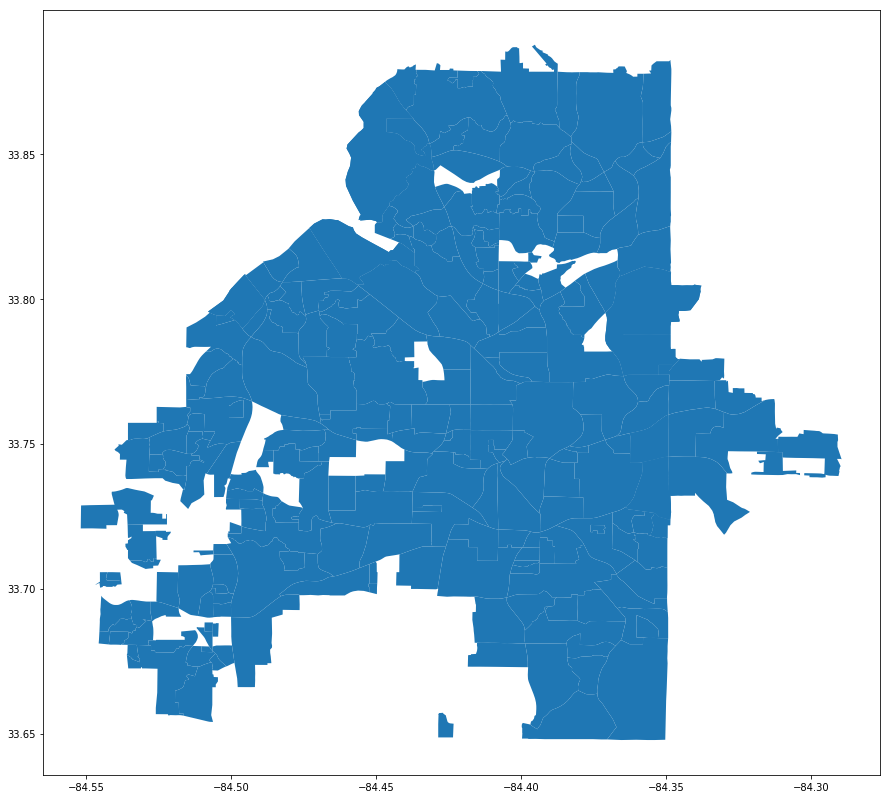

In [41]:
# Merge the neighborhood utility score with the neighborhood boundary information
file_path = 'coffee_data/' + chosen_city + '/map_geo_'+ chosen_city + '.shp'
city_map = gpd.read_file(file_path)
fig,ax = plt.subplots(figsize=(15,15))
city_map.plot(ax=ax)

In [42]:
city_map.head()

,id,geometry
0,0,POLYGON ((-84.50695351401583 33.67451383426722...
1,1,POLYGON ((-84.48658173299992 33.80866994600007...
2,2,POLYGON ((-84.38832055911543 33.70863361816786...
3,3,POLYGON ((-84.48224038299992 33.80574747900005...
4,4,"POLYGON ((-84.4081617693472 33.74150331713682,..."


In [43]:
# comb_gpd = df_neighborhood_reviews.merge(df_city_map,how='inner',on='Name')
comb_gpd = df_city_map
comb_gpd = gpd.GeoDataFrame(comb_gpd[['State','County','City','Name','geometry','coords']].merge(df_neighborhood_reviews[['Name','Utility_Score','Count']],how='inner',on='Name'))

# Turn the tuple in the newly created gpd back into a tuple from a string
def lon_lat_str_to_tuple(string):
    '''
    because coords are converted from tuple to string when 
    '''
    string = string.split(', ')
    lon = float(string[0].split('(')[1])
    lat = float(string[1].split(')')[0])
    return (lon, lat)
comb_gpd.coords   = comb_gpd.coords.apply(lambda x: lon_lat_str_to_tuple(x))

# Now choose to keep only those corresponding to the chosen city to investigate
chosen_city_map_gpd = comb_gpd.loc[comb_gpd['City']==chosen_city]
chosen_city_map_gpd = chosen_city_map_gpd.drop_duplicates(subset='Name', keep='first')# Drop any duplicate neighborhoods


chosen_city_map_gpd.head()

,State,County,City,Name,geometry,coords,Utility_Score,Count
0,GA,Fulton,Atlanta,Brentwood,POLYGON ((-84.50695351401583 33.67451383426722...,"(-84.50510752605473, 33.674667796249054)",1527.950000,10
2,GA,Fulton,Atlanta,Riverside,POLYGON ((-84.48224038299992 33.80574747900005...,"(-84.47219302526278, 33.814965771500056)",802.562500,16
5,GA,Fulton,Atlanta,West End,"POLYGON ((-84.41573181644925 33.7292567399753,...","(-84.4241984822902, 33.73759674276301)",1053.208333,12
7,GA,Fulton,Atlanta,Oakland,POLYGON ((-84.37666423557224 33.74887939924903...,"(-84.3806363362305, 33.748085344451425)",385.075000,20
8,GA,Fulton,Atlanta,Virginia Highland,POLYGON ((-84.36446430200913 33.78767217060184...,"(-84.35715747187595, 33.78075567100692)",965.821429,14


In [44]:
# Read the data
data = chosen_city_map_gpd
main_map = city_map

# Reproject to the same projection
CRS = main_map.crs
data.crs = CRS

data['x'] = [coords[0] for coords in data.coords]
data['y'] = [coords[1] for coords in data.coords]

# Convert GeoDataFrames into GeoJSONDataSource objects (similar to ColumnDataSource)
point_source = GeoJSONDataSource(geojson=data.to_json())
map_source = GeoJSONDataSource(geojson=main_map.to_json())

# Initialize our plot figure
p = figure(title="A test map")

# Add the lines to the map from our GeoJSONDataSource -object (it is important to specify the columns as 'xs' and 'ys')
p.patches('xs', 'ys', source=map_source, color='gray', line_width=3,line_color = "white")

color_mapper = LinearColorMapper(palette='Magma256', low=0, high=1000)

# Add the lines to the map from our 'msource' ColumnDataSource -object
p.circle('x', 'y', source=point_source, size=20, color={'field': 'Utility_Score',
                                                       'transform': color_mapper},name="foo")

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, width=8,  location=(0,0))
p.add_layout(color_bar, 'right')

# Implement interactivity
my_hover = HoverTool(names=["foo"])
my_hover.tooltips = [('Neighborhood Name','@Name'),('Neighborhood Utility Score', '@Utility_Score')]
p.add_tools(my_hover)

# Output filepath
outfp = r"/Users/priyanka/Downloads/points.html"

# Save the map
save(p, outfp)

'/Users/priyanka/Downloads/points.html'

In [45]:
cols_to_drop=['Text','Text_Lemmatized','Time_created','Count']
df_coffee_reviews.drop(columns=cols_to_drop,inplace=True)


In [46]:
# Save to disk for future use
#df_coffee_reviews.to_csv(path+"/"+"coffee_reviews_cleaned.csv")

In [47]:
df_coffee_reviews.shape


(17203, 11)